In [1]:
#Import functions createdon my side
from Functions_custo_by_Nico import * 
#import seaborn
#from matplotlib.image import imread

import cv2
import albumentations as A

import segmentation_models as sm #Check here: https://segmentation-models.readthedocs.io/en/latest/api.html
# calling functions
Test_Imported_Functions()

Segmentation Models: using `tf.keras` framework.
Functions have been properly imported !


In [2]:
import skimage.io as io
import skimage.transform as trans

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, utils
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.losses import categorical_crossentropy
from tensorflow.python.keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

from tensorflow.keras.models import Model


import segmentation_models as sm

# from tensorflow.keras.models import *
# from tensorflow.keras.layers import *
from tensorflow.keras.utils import Sequence
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler


from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from tensorflow.keras.layers import Activation, MaxPool2D, Concatenate

from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import ResNet50

In [4]:
clean_df = pd.read_csv('./clean_df.csv')
clean_df.head()

,Unnamed: 0,Phase,City,File_x,Path_x,File_id1,File_id2,File_type_x,File_unique_index,File_y,Path_y,File_type_y
0,0,test,berlin,berlin_000000_000019_leftImg8bit.png,c:\Users\blanc\OpenClassrooms\IA_Project8_Open...,0,19,leftImg8bit.png,berlin_000000_000019,berlin_000000_000019_gtFine_labelIds.png,c:\Users\blanc\OpenClassrooms\IA_Project8_Open...,gtFine
1,1,test,berlin,berlin_000001_000019_leftImg8bit.png,c:\Users\blanc\OpenClassrooms\IA_Project8_Open...,1,19,leftImg8bit.png,berlin_000001_000019,berlin_000001_000019_gtFine_labelIds.png,c:\Users\blanc\OpenClassrooms\IA_Project8_Open...,gtFine
2,2,test,berlin,berlin_000002_000019_leftImg8bit.png,c:\Users\blanc\OpenClassrooms\IA_Project8_Open...,2,19,leftImg8bit.png,berlin_000002_000019,berlin_000002_000019_gtFine_labelIds.png,c:\Users\blanc\OpenClassrooms\IA_Project8_Open...,gtFine
3,3,test,berlin,berlin_000003_000019_leftImg8bit.png,c:\Users\blanc\OpenClassrooms\IA_Project8_Open...,3,19,leftImg8bit.png,berlin_000003_000019,berlin_000003_000019_gtFine_labelIds.png,c:\Users\blanc\OpenClassrooms\IA_Project8_Open...,gtFine
4,4,test,berlin,berlin_000004_000019_leftImg8bit.png,c:\Users\blanc\OpenClassrooms\IA_Project8_Open...,4,19,leftImg8bit.png,berlin_000004_000019,berlin_000004_000019_gtFine_labelIds.png,c:\Users\blanc\OpenClassrooms\IA_Project8_Open...,gtFine


In [5]:
len(clean_df.loc[clean_df['Phase'] == 'val'])

500

In [43]:
# DATALOADER - Notre classe hérite de la classe Keras.utils.Sequence
# Elle permet de créer un générateur de données
# Cette classe parente vous assure dans le cas ou vous souhaitez utiliser du calcul parallèle avec vos threads, de garantir de parcourir une seule et unique fois vos données au cours d’une époch
class GeneratorCitySpace(keras.utils.Sequence):
    """Load data from dataset to build bacthes
    Args:
        dataset : dataframe listing data and paths
        n_sample : to work with a reduced dataset
        batch_size: Integet number of images in batch.
        resize_width & resize_height: New dimensions after resizing
        phase: allow to set if dataloader shall filter on train, val or test images/masks
        augmentation: Variable defining augmentation of image and mask
    """
    # We provide one dataset, containing labelIds Masks and Images
    def __init__(self, dataset, n_sample=None, batch_size=1, resize_width=256, resize_height=128, phase='train', augmentation=None):
        self.n_sample = n_sample
        self.phase = phase
        if (self.n_sample is None):
            self.dataset = dataset.loc[dataset['Phase'] == self.phase, :]
        else:
            self.dataset = dataset.loc[dataset['Phase'] == self.phase, :].sample(self.n_sample) #ou dataset si on veut prendre tour le jeu de donnée
        self.batch_size = batch_size
        self.resize_width = resize_width
        self.resize_height = resize_height
        self.augmentation = augmentation
        self.on_epoch_end()

    CATS = {
        'void': [0, 1, 2, 3, 4, 5, 6],
        'flat': [7, 8, 9, 10],
        'construction': [11, 12, 13, 14, 15, 16],
        'object': [17, 18, 19, 20],
        'nature': [21, 22],
        'sky': [23],
        'human': [24, 25],
        'vehicle': [26, 27, 28, 29, 30, 31, 32, 33,-1]
    }
    
    def _convert_mask(self,img):
        img = np.squeeze(img)
        mask = np.zeros((img.shape[0], img.shape[1], 8),dtype=np.uint8)
        for i in range(-1, 34):
            if i in self.CATS['void']:
                mask[:,:,0] = np.logical_or(mask[:,:,0],(img==i))
            elif i in self.CATS['flat']:
                mask[:,:,1] = np.logical_or(mask[:,:,1],(img==i))
            elif i in self.CATS['construction']:
                mask[:,:,2] = np.logical_or(mask[:,:,2],(img==i))
            elif i in self.CATS['object']:
                mask[:,:,3] = np.logical_or(mask[:,:,3],(img==i))
            elif i in self.CATS['nature']:
                mask[:,:,4] = np.logical_or(mask[:,:,4],(img==i))
            elif i in self.CATS['sky']:
                mask[:,:,5] = np.logical_or(mask[:,:,5],(img==i))
            elif i in self.CATS['human']:
                mask[:,:,6] = np.logical_or(mask[:,:,6],(img==i))
            elif i in self.CATS['vehicle']:
                mask[:,:,7] = np.logical_or(mask[:,:,7],(img==i))
        return np.array(mask,dtype='uint8') #retrun the mask OneHotEncoded
        #return np.array(np.argmax(mask,axis=2), dtype='uint8') #return the mask with the labelId

    def __getitem__(self, i):
        # collect batch images and masks
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        images = []
        masks = []
        for j in range(start, stop):
            # OpenImages and masks, and apply resize + mask color conversion + Normalization
            image = (cv2.resize(cv2.imread(list(self.dataset['Path_x'])[j]), (self.resize_width, self.resize_height), interpolation = cv2.INTER_AREA)) #image/255 ou normalizedImg
            mask = self._convert_mask(cv2.resize(cv2.imread(list(self.dataset['Path_y'])[j],0), (self.resize_width, self.resize_height), interpolation = cv2.INTER_AREA)) #mask/255
            #mask = cv2.resize(cv2.imread(list(self.dataset['Path_y'])[j]), (self.resize_width, self.resize_height), interpolation = cv2.INTER_AREA) #mask/255
            
            if ((self.augmentation is not None) & (self.phase == 'train')):
                # apply augmentations
                sample = self.augmentation(image=image, mask=mask)
                augmented_image, augmented_mask = sample['image'], sample['mask'] 
                #augmented_image = augmented_image/255
                #augmented_mask = augmented_mask/255
                # append augmented image and mask to batch
                images.append(augmented_image)
                masks.append(augmented_mask)
            image = image/255
            #mask = mask/255


            # append image and mask to batch
            images.append(image)
            masks.append(mask)   

        # transpose list of lists = Data Generator outputs
        image_batch = np.stack(images, axis=0) 
        #Add 1 dimension to return image_batch and mask_batch in 4 dimensions (batch number, height, width, channels), avec channel = 1 pour les masques et =3 pour les images
        #mask_batch = np.expand_dims(np.stack(masks, axis=0), axis = 3)
        mask_batch = np.stack(masks, axis=0) 

        # Data Generator outputs
        return image_batch, mask_batch
    
    def __len__(self):
        """Denotes the number of batches per epoch"""
        return len(self.dataset) // self.batch_size
    
    def on_epoch_end(self):
        """Callback function to shuffle dataset each epoch"""
        np.random.shuffle(self.dataset.values)

In [44]:
# Data Loader preparation
n_sample = None #500 #Pour les tests, nous limitons le jeu de données à 20 images
batch_size = 5 #Pour les tests, nous limitons le batch_size à 2 images
resize_width = 256
resize_height = 128
# Declare an augmentation pipeline
# augmentation = None 
augmentation = A.Compose(
                    [#A.RandomCrop(width=512, height=256), 
                    A.Rotate(25),
                    A.OneOf([A.RGBShift(), A.HueSaturationValue()]),
                    #A.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0), 
                    #A.IAAPerspective(p=0.5), 
                    #A.HorizontalFlip(p=0.5),
                    A.OneOf([A.CLAHE(), A.RandomBrightnessContrast(), A.RandomGamma()]), 
                    ])


# Generators
train_generators = GeneratorCitySpace(clean_df, n_sample, batch_size, resize_width, resize_height, 'train', augmentation)
val_generators = GeneratorCitySpace(clean_df, n_sample, batch_size, resize_width, resize_height, 'val', augmentation)
test_generators = GeneratorCitySpace(clean_df, n_sample, batch_size, resize_width, resize_height, 'test', augmentation)

# #Autres Generator from Keras
# #Tuto here: https://vijayabhaskar96.medium.com/tutorial-on-keras-imagedatagenerator-with-flow-from-dataframe-8bd5776e45c1
# #Doc here: https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator#flow_from_dataframe
# from keras_preprocessing.image import ImageDataGenerator

In [45]:
print(train_generators[0][1].shape)
#np.unique(train_generators[0][1])
print(train_generators[0][0].shape)

(10, 128, 256, 8)
(10, 128, 256, 3)


In [46]:
len(train_generators)

595

# Chargement du modèle UNET

In [8]:

n_filters = 32 #Variable used in Neural Network Convolutions steps
nb_class = 8
#Load model architecture
model_test = build_unet_block((resize_height, resize_width, 3), nb_class, n_filters)

# Inspiré de https://github.com/hlamba28/UNET-TGS/blob/master/
#model_test = get_unet(Input((resize_width, resize_height, 3), name='img'), n_filters=n_filters, dropout=0.05, batchnorm=True)

#Load model architecture
#model_test = build_unet()

### Choose the Metric

Refer to:
 - [Article on Semantic Segmentation Metrics](https://ilmonteux.github.io/2019/05/10/segmentation-metrics.html)
 - [DICE vs IOU](https://stats.stackexchange.com/questions/273537/f1-dice-score-vs-iou)
 - 

In [156]:
# MeanIOU meant to work with the one-hot encoded label
# In this notebook, the label is not one hot encoded but simply integer coded
# So in order to use the MeanIOU for this case, it's needed to use as follows

class UpdatedMeanIoU(tf.keras.metrics.MeanIoU):
    def __init__(self,
               y_true=None,
               y_pred=None,
               num_classes=None,
               name=None,
               dtype=None):
        super(UpdatedMeanIoU, self).__init__(num_classes = num_classes,name=name, dtype=dtype)

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.math.argmax(y_pred, axis=-1)
        return super().update_state(y_true, y_pred, sample_weight)

In [165]:
def mean_IOU(y_true, y_pred):
    m = tf.keras.metrics.MeanIoU(num_classes=8)
    m.update_state(y_true, tf.argmax(y_pred, 3))
    return m.result()

In [173]:
class UpdatedMeanIoU(tf.keras.metrics.MeanIoU):
  def __init__(self,
               y_true=None,
               y_pred=None,
               num_classes=None,
               name=None,
               dtype=None):
    super(UpdatedMeanIoU, self).__init__(num_classes = num_classes,name=name, dtype=dtype)

  def update_state(self, y_true, y_pred, sample_weight=None):
    y_pred = tf.math.argmax(y_pred, num_classes=8)
    return super().update_state(y_true, y_pred, sample_weight)

### Fit the Model



In [10]:
# Fit model
learning_rate = 1e-3
# define optomizer
optim = keras.optimizers.Adam(learning_rate)

# Select Metric
# from tensorflow.keras.metrics import MeanIoU
#metric = tf.keras.metrics.MeanIoU(num_classes=nb_class)
#metric = tf.keras.metrics.OneHotIoU(num_classes=nb_class) #, target_class_ids=[0, 7])

#import segmentation_models as sm
metric = sm.metrics.IOUScore() #sm.metrics.IOUScore(threshold=0.5)



# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
# set class weights for dice_loss (car: 1.; pedestrian: 2.; background: 0.5;)
dice_loss = sm.losses.DiceLoss() 
# focal_loss = sm.losses.BinaryFocalLoss() if n_classes == 1 else sm.losses.CategoricalFocalLoss()
# total_loss = dice_loss + (1 * focal_loss)

#mean_iou_metric = Mean_IoU_custom()
# Mean IOU Documentation is available here: https://www.tensorflow.org/api_docs/python/tf/keras/metrics/MeanIoU
#model_test.compile(optimizer=Adam(lr = 1e-4), loss='sparse_categorical_crossentropy',metrics=['accuracy'])
model_test.compile(optimizer=optim, loss='categorical_crossentropy', metrics=[metric]) #if OneHotEncoded
   #model_test.compile(optimizer=optim, loss=[dice_loss, 'categorical_crossentropy'], metrics=[metric]) #if OneHotEncoded
#model_test.compile(optimizer=Adam(lr = 1e-5), loss='sparse_categorical_crossentropy', metrics=[tf.keras.metrics.MeanIoU(num_classes=8)]) #If LabelEncoded
#model_test.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy',metrics=['accuracy'])

model_test.summary()

Model: "U-Net"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 256, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 256, 32) 9248        conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 64, 128, 32)  0           conv2d_1[0][0]                   
______________________________________________________________________________________________

In [38]:
len(train_generators)


595

In [11]:
# callbacks that will be used during training
#earlystopper = EarlyStopping(monitor='val_loss', mode = 'min', patience=5) #ou  (patience=10, verbose=1, mode = 'auto') 
earlystopper = EarlyStopping(patience=10, verbose=1, mode = 'auto')

#checkpoint = ModelCheckpoint(filepath = './Models/checkpoints/weights.h5', verbose=True, save_best_only=True) #monitor='loss' ou monitor='val_iou_score' #mode='max' #filepath='model.{epoch:02d}-{val_loss:.2f}.h5'
checkpoint = ModelCheckpoint(filepath = './Models/checkpoints/weights.h5', verbose=True, save_best_only=True, monitor='val_iou_score', mode='max')

#reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-4)
reduce_lr = ReduceLROnPlateau(factor=0.1, cooldown= 10, patience=10, verbose=1, min_lr=1e-5)

n_epochs = 50

#Train model
results = model_test.fit_generator(
                            train_generators, 
                            validation_data = val_generators, 
                            validation_steps = (len(clean_df.loc[clean_df['Phase'] == 'val']) // batch_size) #(n_sample // batch_size), #len(valX) // batch_size.
                            steps_per_epoch = (len(clean_df.loc[clean_df['Phase'] == 'train']) // batch_size) #(n_sample // batch_size), #len(trainX) // batch_size
                            epochs = n_epochs, 
                            #workers=30,
                            verbose = True,
                            use_multiprocessing=True,
                            callbacks = [checkpoint, reduce_lr, earlystopper] #, reduce_lr
                            )

# results = model_test.fit(
#                         train_generators, 
#                         validation_data=val_generators, 
#                         epochs=1, 
#                         #callbacks=[checkpoint, early_stopping]
#                         )

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/50
100/100 [==============================] - ETA: 0s - loss: 2.8909 - iou_score: 0.1046WARNING:tensorflow:multiprocessing can interact badly with TensorFlow, causing nondeterministic deadlocks. For high performance data pipelines tf.data is recommended.

Epoch 00001: val_iou_score improved from -inf to 0.14645, saving model to ./Models/checkpoints\weights.h5
100/100 [==============================] - 73s 727ms/step - loss: 2.8909 - iou_score: 0.1046 - val_loss: 1.2166 - val_iou_score: 0.1464
Epoch 2/50
100/100 [==============================] - ETA: 0s - loss: 1.1226 - iou_score: 0.1736WARNING:tensorflow:multiprocessing can interact badly with TensorFlow, causing nondeterministic deadlocks. For high performance data pipelines tf.data is recommended.

Epoch 00002: val_iou_score improved from 0.14645 to 0.21081, saving model to ./Models/checkpoints\weights.h5
100/100 [==============================] - 84

In [11]:
tf.keras.utils.plot_model(
    model_test,
    to_file='model.png',
    show_shapes=True,
    #show_dtype=False,
    show_layer_names=True,
    rankdir='TB',
    #expand_nested=False,
    #dpi=96,
    #layer_range=None,
    #show_layer_activations=False
)


Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.


In [27]:
# def display_learning_curves_iou(history):
#     iou = history.history["iou_score"]
#     val_iou = history.history["val_iou_score"]

#     loss = history.history["loss"]
#     val_loss = history.history["val_loss"]
#     epochs_range=range(1, len(iou) + 1)
#     #epochs_range = range(n_epochs)

#     fig = plt.figure(figsize=(15,5))

#     plt.subplot(1,2,1)
#     plt.plot(epochs_range, iou, label="train iou_score")
#     plt.plot(epochs_range, val_iou, label="validataion iou_score")
#     plt.title("iou_score")
#     plt.xlabel("Epoch")
#     plt.ylabel("iou_score")
#     plt.legend(loc="upper left")

#     plt.subplot(1,2,2)
#     plt.plot(epochs_range, loss, label="train loss")
#     plt.plot(epochs_range, val_loss, label="validataion loss")
#     plt.title("Loss")
#     plt.xlabel("Epoch")
#     plt.ylabel("Loss")
#     plt.legend(loc="upper right")

#     plt.suptitle(f"IoU Socre and Loss evolution during {model_test.name} training, (stopped by callback at epochs : {len(iou)})  ")
#     #fig.tight_layout()
#     plt.show()

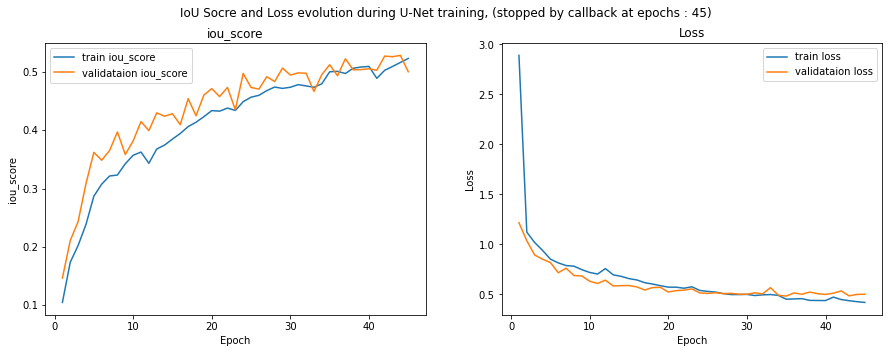

In [28]:
# Display learning curves 
display_learning_curves_iou(model_test.history)

In [29]:
#saveResult("./results/val",results)
model_test.save('./Models/model_test_{model_test.name}.h5')

In [21]:
test_generators = GeneratorCitySpace(clean_df, n_sample, batch_size, resize_width, resize_height, 'test', augmentation)
results = model_test.predict(test_generators,verbose=1)



100/100 [==============================] - 53s 527ms/step


In [24]:
results.shape
#plt.show(results[0][:][:][:])
#cv2.imshow('Image test', results[0][:][:][1])
#cv2.waitKey(0)


(500, 128, 256, 8)

In [25]:
results[0].shape

(128, 256, 8)

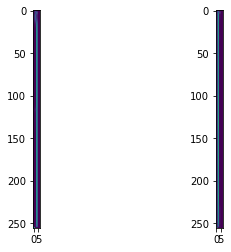

In [28]:
for j in range(2):
    #print(filepaths[j])
    plt.subplot(120 + 1 + j)
    #plt.title(title[j])
    image = results[j][:][:][1] #cv2.imread(filepaths[j])
    plt.imshow(image)
    plt.grid(False)
#plt.suptitle(f'Images and Masks {(i[0])} {(i[1])}_{(i[4])}_{(i[5])}')
plt.show()



In [15]:
# img = results[0][:][:][7] #(np.zeros(results[0][:][:][7]))
# plt.imshow("image", img)
# plt.grid(False)
# plt.show()


## Evaluation de la performance

Nous évaluerions la performance de nos modèles sur différents critères (voir ci-dessous).
Une documentation sur les fonctions de pertes pour la segmentation d'images est [disponible ici](https://lars76.github.io/2018/09/27/loss-functions-for-segmentation.html)

| Loss | Metric | Intersection vs. Union | Confusion Matrix | Pros | Cons|
|------|--------|----------------|------|-----|------|
| Sparse Categorical Cross-entropy | Pixel Accuracy | $ - $ | $ \frac{TP + TN}{TP + FP + TN + FN} $ | Easy to interpret | Bad with imbalanced target classes. |
| Dice | F1 | $ \frac{2 \lvert\lvert A \cap B \rvert\rvert}{\lvert\lvert A \rvert\rvert + \lvert\lvert B \rvert\rvert} $ | $ \frac{2 TP}{2 TP + FP + FN} $ | Good with imbalanced target classes. | Not easy to interpret. |
| Jaccard | Intersection over Union (IoU) | $ \frac{\lvert\lvert A \cap B \rvert\rvert}{\lvert\lvert A \cup B \rvert\rvert} $ | $ \frac{TP}{TP + FP + FN} $ | Easy to interpret. Good with imbalanced target classes. |  |

Ici, nous voyons que le coéfficient de DICE est similaire à l'index de Jaccard (Intersection oer Union, IoU).
le coeefcient de DICE (DC) est supérieur ou égale à IoU.
Il sera utilisé dans notre cas comme fonction de perte, utilisé durant l'entrainement du modèle.

In [28]:
#Load model architecture
model_test = build_unet((resize_width, resize_height, 3), nb_class)

# Ffrom Kaggle https://www.kaggle.com/code/michaelcripman/road-segmentation-unet-keras-implementation
# Or From GitHub : https://github.com/srihari-humbarwadi/cityscapes-segmentation-with-Unet/blob/master/batch_training.py
def dice_coeff(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return score
        
#metrics=[dice_coeff(y_true, y_pred), tf.keras.metrics.MeanIoU(30, name = 'iou')]
metrics=[dice_coeff, 'accuracy']
#metrics=['accuracy']

# Fit model
#earlystopper = EarlyStopping(patience=3, verbose=1)
#checkpointer = ModelCheckpoint('model-dsbowl2018-1.h5', verbose=1, save_best_only=True)
#checkpointer = ModelCheckpoint('unet_membrane.hdf5', monitor='loss',verbose=1, save_best_only=True)
tb = TensorBoard(log_dir='logs', write_graph=True)
mc = ModelCheckpoint(mode='max', filepath='models/unet_1_lossDICE.h5', monitor='acc', save_best_only='True', save_weights_only='True', verbose=1)
es = EarlyStopping(mode='max', monitor='acc', patience=6, verbose=1)
callbacks = [tb, mc, es]


# The learning rate used during optimization using Adam.
learning_rate = "0.001"  #@param [ "0.1" , "0.001" , "0.0001" , "0.05" ]
#Train model
model_test.compile(optimizer=Adam(lr = 1e-5), loss='sparse_categorical_crossentropy',metrics=metrics)

#model_test.summary()
results = model_test.fit_generator(
                            train_generators, 
                            validation_data=val_generators, 
                            validation_steps=10, 
                            #steps_per_epoch=250,
                            epochs=1, 
                            #workers=30,
                            #verbose=1,
                            #use_multiprocessing=True,
                            #callbacks=[earlystopper,checkpointer] #callbacks
                            )

InvalidArgumentError: Incompatible shapes: [2621440] vs. [20971520]
	 [[{{node metrics_6/dice_coeff/mul}}]]

In [ ]:
# Ffrom Kaggle https://www.kaggle.com/code/michaelcripman/road-segmentation-unet-keras-implementation
def dice_coeff(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return score
        
#metrics=[dice_coeff(y_true, y_pred), tf.keras.metrics.MeanIoU(30, name = 'iou')]
metrics=[dice_coeff(y_true, y_pred), 'accuracy']


def dice_loss(y_true, y_pred):
    loss = 1 - dice_coeff(y_true, y_pred)
    return loss

def total_loss(y_true, y_pred):
    loss = binary_crossentropy(y_true, y_pred) + (3*dice_loss(y_true, y_pred))
    return loss


#From Blog : https://lars76.github.io/2018/09/27/loss-functions-for-segmentation.html
def dice_loss(y_true, y_pred):
  y_true = tf.cast(y_true, tf.float32)
  y_pred = tf.math.sigmoid(y_pred)
  numerator = 2 * tf.reduce_sum(y_true * y_pred)
  denominator = tf.reduce_sum(y_true + y_pred)

  return 1 - numerator / denominator

In [ ]:
# segmentation_models could also use `tf.keras` if you do not have Keras installed
# or you could switch to other framework using `sm.set_framework('tf.keras')`
import tensorflow.keras.segmentation_models as sm

# define optomizer
optim = tensorflow.keras.optimizers.Adam(LR)

# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
# set class weights for dice_loss (car: 1.; pedestrian: 2.; background: 0.5;)
dice_loss = sm.losses.DiceLoss(class_weights=np.array([1, 2, 0.5])) 
focal_loss = sm.losses.BinaryFocalLoss() if n_classes == 1 else sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
# total_loss = sm.losses.binary_focal_dice_loss # or sm.losses.categorical_focal_dice_loss 

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]


# Fonction de Loss

In [ ]:
def dice_coeff(y_true, y_pred,smooth=1.):
    y_true_f = K.cast(K.flatten(y_true), K.floatx())
    y_pred_f = K.cast(K.flatten(y_pred), K.floatx())
    intersection = K.sum(y_true_f * y_pred_f)
    union = K.sum(y_true_f) +  K.sum(y_pred_f)
    score = (2. * intersection + smooth) / (union + smooth)
    return score

def dice_loss(y_true, y_pred):
    return 1 - dice_coeff(y_true, y_pred)

def combinaison_loss(y_true, y_pred):
    loss = categorical_crossentropy(y_true, y_pred) + (3.*dice_loss(y_true, y_pred))
    return loss

def combinaison_loss_2(y_true, y_pred):
    loss = categorical_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)
    return loss

# def dice_coeff(pred, target):
#     pred = (pred > 0).float()
#     return 2. * (pred*target).sum() / (pred+target).sum()
            

In [ ]:
model_checkpoint_dice_loss, file_weight_dice_loss = fnct.create_checkpoint_callback("./checkpoint/","model_unet_dice_loss", mean_iou_metric)

In [ ]:
history = model_test.fit(data_train,  
                    verbose=1,
                    epochs=50,
                    use_multiprocessing=True,
                    workers=30,
                    validation_data=data_val,
                    callbacks=[model_checkpoint_dice_loss])

In [ ]:
#Load model architecture
model_test = build_unet((resize_width, resize_height), nb_class)
model_test.compile(optimizer="adam", loss=dice_loss,metrics=[mean_iou_metric])

In [ ]:
plot_history(history,scoring=["mean_iou","loss"],log_scale=[False,True])

In [ ]:
loss_score, mean_iou_score = model_test.evaluate(data_val)
print("Le meilleur modèle obtient un score de :",mean_iou_score)
print("Le score final de la fonction loss est de :",loss_score)